In [15]:
%load_ext autoreload
%autoreload 2
from mtsccleav import *
from aeon.utils.conversion import convert_collection
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
ts_panel = load_as_pd_multiindex("../data/01_single_multi_eq.csv")
X = construct_X(ts_panel, include_five_p_cleav=True, include_prob=False, include_ss=False)
X_convert=convert_collection(X, "np-list")
y = np.concatenate((np.full((1, 827), 'cleav'), np.full((1, 827), 'non_cleav')), axis=None)
labelencoder = LabelEncoder()
y_transform = labelencoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X_convert, y_transform, test_size=0.2, random_state=42)

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import accuracy_score
from aeon.datasets import load_basic_motions
from aeon.transformations.collection.convolution_based import Rocket

# # Step 1: Load the dataset
# X_train, y_train = load_basic_motions(split="train", return_type="numpy3d")
# X_test, y_test = load_basic_motions(split="test", return_type="numpy3d")

# Step 2: Fit ROCKET transformer
rocket = Rocket(n_kernels=10_000, random_state=42)
rocket.fit(X_train)
X_train_trans = rocket.transform(X_train)
X_test_trans = rocket.transform(X_test)

# Step 3: Train a classifier
clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
clf.fit(X_train_trans, y_train)
print("Test accuracy:", accuracy_score(y_test, clf.predict(X_test_trans)))


Test accuracy: 0.7764350453172205


In [80]:
def sliding_window_importance(sample, rocket, clf, window_size=4):
    # Step 1: Original score from classifier
    orig_feat = rocket.transform(sample[None, ...])
    orig_scores = clf.decision_function(orig_feat)  # shape: (1,) or (1, C)
    pred_class = clf.predict(orig_feat)[0]

    # Step 2: Determine the relevant class score
    if orig_scores.ndim == 1:  # binary case → shape: (1,)
        orig_score = orig_scores[0]  # scalar
        class_index = int(pred_class == clf.classes_[1])  # class 1 = positive class
    else:  # multiclass → shape: (1, n_classes)
        orig_score = orig_scores[0]  # vector of class scores
        class_index = list(clf.classes_).index(pred_class)

    if isinstance(orig_score, np.ndarray):
        orig_score = orig_score[class_index]  # class-specific score

    # Step 3: Perturb each time window and record drop in score
    importance = []
    for start in range(sample.shape[1] - window_size + 1):
        perturbed = sample.copy()
        perturbed[:, start:start + window_size] = 0.0  # mask window

        pert_feat = rocket.transform(perturbed[None, ...])
        pert_scores = clf.decision_function(pert_feat)

        if pert_scores.ndim == 1:  # binary
            pert_score = pert_scores[0]
            pert_class_index = int(pred_class == clf.classes_[1])
        else:
            pert_score = pert_scores[0]
            pert_class_index = class_index

        if isinstance(pert_score, np.ndarray):
            pert_score = pert_score[pert_class_index]

        # Importance = drop in decision confidence
        drop = orig_score - pert_score
        importance.append(drop)

    return np.array(importance)


In [81]:
i = 0  # test sample index
sample = X_test[i]  # shape (channels, time)

importance = sliding_window_importance(sample, rocket, clf, window_size=4)

In [ ]:


# # Step 4: Define perturbation-based importance function
# def mask_segment(X, start, length, fill_value=0.0):
#     """Mask a time window across all channels"""
#     X_masked = X.copy()
#     X_masked[:, start:start + length] = fill_value
#     return X_masked

# def sliding_window_importance(sample, rocket, clf, window_size=5):
#     """
#     Estimate importance of each time window by how much
#     it affects classification confidence when masked.
#     """
#     orig_feat = rocket.transform(sample[None, ...])
#     orig_proba = clf.decision_function(orig_feat)[0]
#     true_class = clf.predict(orig_feat)[0]

#     importances = []
#     for start in range(sample.shape[1] - window_size + 1):
#         masked = sample.copy()
#         masked[:, start:start+window_size] = 0.0  # zero-out across channels
#         masked_feat = rocket.transform(masked[None, ...])
#         masked_score = clf.decision_function(masked_feat)[0]
#         print("hello",masked_score)
#         # Score drop for the predicted class
#         class_index = list(clf.classes_).index(true_class)
#         print(class_index)
#         print(orig_proba[class_index])
#         drop = orig_proba[class_index] - masked_score[class_index]
#         importances.append(drop)

#     return np.array(importances)

# # Step 5: Run on one test sample
# i = 0  # test sample index
# sample = X_test[i]  # shape (channels, time)

# importance = sliding_window_importance(sample, rocket, clf, window_size=4)

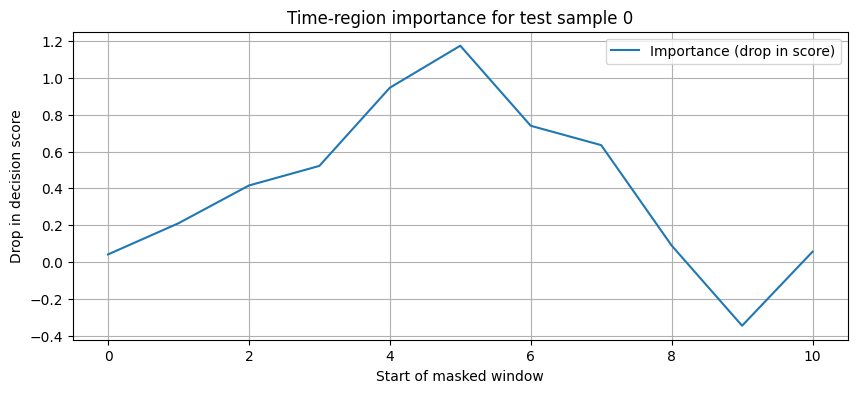

In [82]:


# Step 6: Plot importance
plt.figure(figsize=(10, 4))
plt.plot(importance, label="Importance (drop in score)")
plt.title(f"Time-region importance for test sample {i}")
plt.xlabel("Start of masked window")
plt.ylabel("Drop in decision score")
plt.grid(True)
plt.legend()
plt.show()


In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import accuracy_score
from aeon.datasets import load_basic_motions
from aeon.transformations.collection.convolution_based import Rocket

# Step 1: Load dataset
X_train, y_train = load_basic_motions(split="train", return_type="numpy3d")
X_test, y_test = load_basic_motions(split="test", return_type="numpy3d")

# Step 2: Train ROCKET + classifier
rocket = Rocket(n_kernels=10000, random_state=42)
rocket.fit(X_train)
X_train_trans = rocket.transform(X_train)
X_test_trans = rocket.transform(X_test)

clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
clf.fit(X_train_trans, y_train)
print("Test accuracy:", accuracy_score(y_test, clf.predict(X_test_trans)))


Test accuracy: 0.975


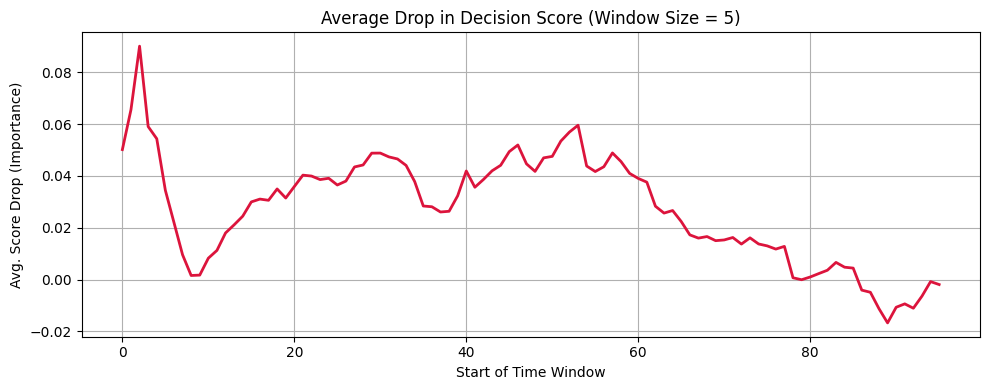

In [55]:

# Step 3: Perturbation function (single sample)
def sliding_window_importance(sample, rocket, clf, window_size=5):
    orig_feat = rocket.transform(sample[None, ...])
    orig_proba = clf.decision_function(orig_feat)[0]
    true_class = clf.predict(orig_feat)[0]
    class_index = list(clf.classes_).index(true_class)

    importance = []
    for start in range(sample.shape[1] - window_size + 1):
        perturbed = sample.copy()
        perturbed[:, start:start + window_size] = 0.0
        pert_feat = rocket.transform(perturbed[None, ...])
        pert_proba = clf.decision_function(pert_feat)[0]
        drop = orig_proba[class_index] - pert_proba[class_index]
        importance.append(drop)
    return np.array(importance)


In [69]:
X_test.shape[2]

AttributeError: 'list' object has no attribute 'shape'

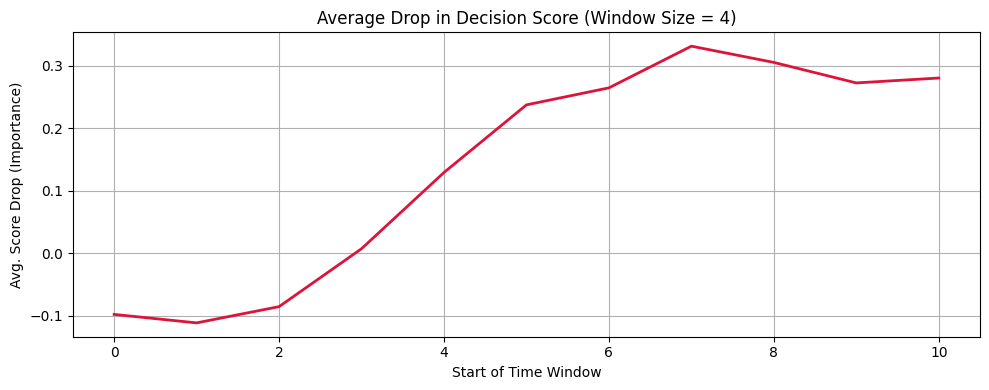

In [83]:

# Step 4: Loop over all test samples
window_size = 4
# n_windows = X_test.shape[2] - window_size + 1
all_importances = []

for i in range(len(X_test)):
    imp = sliding_window_importance(X_test[i], rocket, clf, window_size=window_size)
    all_importances.append(imp)

# Step 5: Average across samples
avg_importance = np.mean(all_importances, axis=0)

# Step 6: Plot average importance curve
plt.figure(figsize=(10, 4))
plt.plot(avg_importance, color="crimson", lw=2)
plt.title(f"Average Drop in Decision Score (Window Size = {window_size})")
plt.xlabel("Start of Time Window")
plt.ylabel("Avg. Score Drop (Importance)")
plt.grid(True)
plt.tight_layout()
plt.show()
